In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
import xesmf as xe
import warnings
from defs import lon180cesm, lon180, salmask, latweights, makedz

In [2]:
datafolder = ''

In [3]:
experiment = 'Eoi400' 
model = 'HadGEM3'
folder = datafolder+'Raw_data/'+model+'/'

In [4]:
dsV = xr.open_dataset(folder+experiment+'/vo_100yr.nc')
dsS = xr.open_dataset(folder+experiment+'/so_100yr.nc')
dsr = xr.open_dataset(folder+experiment+'/subbasins_CMIP6.nc')

#Rename lats/lons to differentiate between U and T grid
dsV = dsV.rename({'nav_lon': 'ULONG', 'nav_lat': 'ULAT', 'depthv': 'olevel'})
dsS = dsS.rename({'nav_lon': 'TLONG', 'nav_lat': 'TLAT', 'deptht': 'olevel'})
dsr = dsr.rename({'nav_lon': 'TLONG', 'nav_lat': 'TLAT'})

## Separation MOC and gyre FW Atlantic

In [5]:
salt = dsS.so
region = dsr.atlmsk

regridder = xe.Regridder(dsV, dsS, 'bilinear', periodic = True, ignore_degenerate=True)
vo = dsV.vo.fillna(0)*100
vvel = regridder(vo) #cm/s
vvel = vvel*salt/salt

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


Create DXT grid

In [6]:
dphi = np.zeros([332,362])
lat = dsS.TLAT.values
dphi[:,1:] = lat[:,1:]-lat[:,:-1]
dphi[:,0] = lat[:,0]-lat[:,-1]
dphi = np.radians(dphi)

dtheta = np.zeros([332,362])
lon = dsS.TLONG.values
dtheta[:,1:] = lon[:,1:]-lon[:,:-1]
dtheta[:,0] = lon[:,0]-lon[:,-1]

for j in range(332):
    for i in range(200,300):
        if dtheta[j,i] < -300:
            dtheta[j,i] = dtheta[j,i]+360
dtheta = np.radians(dtheta)

phi1 = np.zeros([332,362])
phi1[:,0] = lat[:,-1]
phi1[:,1:] = lat[:,:-1]
phi1 = np.radians(phi1)

phi2 = np.radians(lat)

r = 6.37122e8 #radius Earth in cm
d = 2*r*np.arcsin(np.sqrt(np.sin(dphi/2)**2+np.cos(phi1)*np.cos(phi2)*np.sin(dtheta/2)**2)) #Distance between adjacent cells in i dimension on U grid [cm]
dsS['d'] = xr.DataArray(data=d, dims=("j","i")) 
DXT = np.zeros([332,362])
DXT[:,:-1] = (d[:,1:]+d[:,:-1])/2
DXT[:,-1] = (d[:,0]+d[:,-1])/2

dsS['DXT'] = xr.DataArray(data=DXT, dims=("y","x")) #Grid lengths centered on T-points [cm]

Create DZ array

In [7]:
#1-D array with spacing of depth grid
ds = dsS.copy(deep=True)

dz = np.zeros(len(ds.olevel))
dz[0] = ds.olevel[0].values*2
depth = dz[0]
for i in range(1,len(ds.olevel)):
    dz[i] = (ds.olevel[i]-depth)*2
    depth = depth+dz[i]
dz = dz*100 #Depth spacing. Units: cm
dsS['DZ'] = xr.DataArray(data=dz, dims=("olevel"))
dsS['DZ'] = xr.DataArray(data=dz, dims=("olevel"))
DZ = dsS.DZ

In [8]:
#Define reference salinity S0 as average Atlantic salinity
folder2 = datafolder+'Processed/'
dssal = xr.open_dataset(folder2+model+'/'+experiment+'/so_1x1_100yr.nc')
dssal = lon180(dssal)

S0 = dssal.so.where(salmask()>-1).weighted(makedz(dssal)).mean(dim='z').weighted(latweights()).mean()

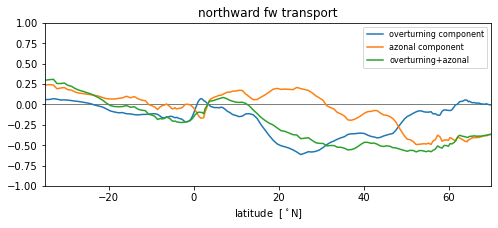

In [9]:
VVEL = vvel.where(region>0) #cm/s
SALT = salt.where(region>0)  #  [g/kg]

def zonal_means(x, dx):
    xint = (x*dx).sum('x')  # [x-unit * cm]
    zm = xint/dx.sum('x')   # [x-unit]
    return xint, zm

#zonal means
VVEL_xint, VVEL_zm = zonal_means(VVEL, dsS.DXT.where(VVEL<10000))
SALT_xint, SALT_zm = zonal_means(SALT, dsS.DXT.where(VVEL<10000))

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components
SALT_prime = (SALT - SALT_zm) # azonal salt component (x,y,z) 
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) 

#integrate to compute FW transports
Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dsS.DXT*dsS.DZ).sum(dim=['x','olevel']))/1e12 # 1 Sv = 1e12 cm^3/s
Faz = (-1/S0*(VVEL_prime*SALT_prime*dsS.DXT*dsS.DZ).sum(dim=['x','olevel']))/1e12
Ftotal = (-1/S0*(VVEL*(SALT-S0)*dsS.DXT*dsS.DZ).sum(dim=['x','olevel']))/1e12

#auxiliary latitudes
lats = dsS.TLAT.where(region>0).mean(dim='x')

plt.figure(figsize=(8,3))
plt.axhline(0,c='k',lw=.5)
plt.plot(lats, Fov, label='overturning component')

plt.plot(lats, Faz, label='azonal component')
plt.plot(lats, Ftotal, label='overturning+azonal')
plt.title('northward fw transport')
plt.xlim([-35,70])
plt.ylim([-1,1])
plt.xlabel(r'latitude  [$^\circ$N]')
plt.legend(fontsize=8)


In [12]:
dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[134:-2]), Faz=(["lat"], Faz[134:-2]), Ftot=(["lat"], Ftotal[134:-2])), coords = dict(lat = lats[134:-2].values))    
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_100yr.nc')

## FW Labrador Sea

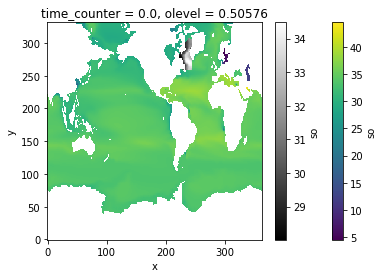

In [13]:
#Check region
salt[0].plot()
salt[0].where(region>0).where(dsS.TLONG<-45).where(dsS.TLAT>=50).where(dsS.TLONG>-70).where(dsS.TLAT<75).plot(cmap='gray')

In [15]:
VVEL = vvel.where(region>0).where(dsS.TLONG<-45).where(dsS.TLAT>=50).where(dsS.TLONG>-70).where(dsS.TLAT<75) #cm/s
SALT = salt.where(region>0).where(dsS.TLONG<-45).where(dsS.TLAT>=50).where(dsS.TLONG>-70).where(dsS.TLAT<75)  #  [g/kg]

#zonal means
VVEL_xint, VVEL_zm = zonal_means(VVEL, dsS.DXT.where(VVEL<10000))
SALT_xint, SALT_zm = zonal_means(SALT, dsS.DXT.where(VVEL<10000))

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components
SALT_prime = (SALT - SALT_zm) # azonal SALT component (x,y,z)
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) 

#integrate for FW transports
Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dsS.DXT*dsS.DZ).sum(dim=['x','olevel']))/1e12 # 1 Sv = 1e12 cm^3/s
Faz = (-1/S0*(VVEL_prime*SALT_prime*dsS.DXT*dsS.DZ).sum(dim=['x','olevel']))/1e12
Ftotal = (-1/S0*(VVEL*(SALT-S0)*dsS.DXT*dsS.DZ).sum(dim=['x','olevel']))/1e12

#auxiliary latitudes
lats = dsS.TLAT.where(region>0).where(dsS.TLONG<-45).where(dsS.TLAT>=50).where(dsS.TLONG>-70).where(dsS.TLAT<75).mean(dim='x')

dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[265:-34]), Faz=(["lat"], Faz[265:-34]), Ftot=(["lat"], Ftotal[265:-34])), coords = dict(lat = lats[265:-34].values))    
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_Lab_100yr.nc')

## Separation MOC and gyre FW Fram

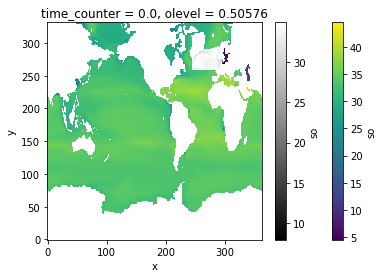

In [16]:
#Check region
salt[0].plot()
salt[0].where(region>0).where(dsS.TLONG>=-45).where(dsS.TLAT>=50).where(dsS.TLAT<70).where(dsS.TLONG<15).plot(cmap='gray')

In [17]:
VVEL = vvel.where(region>0).where(dsS.TLONG>=-45).where(dsS.TLAT>=50).where(dsS.TLAT<70).where(dsS.TLONG<15) #cm/s
SALT = salt.where(region>0).where(dsS.TLONG>=-45).where(dsS.TLAT>=50).where(dsS.TLAT<70).where(dsS.TLONG<15)  #  [g/kg]

#zonal means
VVEL_xint, VVEL_zm = zonal_means(VVEL, dsS.DXT.where(VVEL<10000))
SALT_xint, SALT_zm = zonal_means(SALT, dsS.DXT.where(VVEL<10000))

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components 
SALT_prime = (SALT - SALT_zm) # azonal SALT component (x,y,z) 
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) 

#integrate
Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dsS.DXT*dsS.DZ).sum(dim=['x','olevel']))/1e12 # 1 Sv = 1e12 cm^3/s
Faz = (-1/S0*(VVEL_prime*SALT_prime*dsS.DXT*dsS.DZ).sum(dim=['x','olevel']))/1e12
Ftotal = (-1/S0*(VVEL*(SALT-S0)*dsS.DXT*dsS.DZ).sum(dim=['x','olevel']))/1e12

#auxiliary latitudes
lats = dsS.TLAT.where(region>0).where(dsS.TLONG>=-45).where(dsS.TLAT>=50).where(dsS.TLAT<70).where(dsS.TLONG<15).mean(dim='x')

dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[265:-44]), Faz=(["lat"], Faz[265:-44]), Ftot=(["lat"], Ftotal[265:-44])), coords = dict(lat = lats[265:-44].values))    
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_Fram_100yr.nc')


## FW Bering Strait

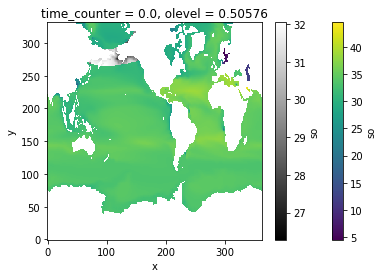

In [18]:
salt[0].plot()
salt[0].where(dsS.x>70).where(dsS.x<170).where(dsS.TLAT>=55).where(dsS.TLAT<70).plot(cmap='gray')

In [19]:
if experiment == 'E280':
    VVEL = vvel.where(dsS.x>70).where(dsS.x<170).where(dsS.TLAT>=55).where(dsS.TLAT<70) #cm/s
    SALT = salt.where(dsS.x>70).where(dsS.x<170).where(dsS.TLAT>=55).where(dsS.TLAT<70)  #  [g/kg]
    VVEL_xint, VVEL_zm = zonal_means(VVEL, dsS.DXT.where(VVEL<10000))
    SALT_xint, SALT_zm = zonal_means(SALT, dsS.DXT.where(VVEL<10000))

    SALT_zm_3D = SALT/SALT
    SALT_zm_3D = SALT_zm_3D*SALT_zm

    VVEL_zm_3D = VVEL/VVEL
    VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

    #azonal components on u grid
    SALT_prime = (SALT - SALT_zm) # azonal SALT component (x,y,z) 
    VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) 

    Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dsS.DXT*dsS.DZ).sum(dim=['x','olevel']))/1e12 # 1 Sv = 1e12 cm^3/s
    Faz = (-1/S0*(VVEL_prime*SALT_prime*dsS.DXT*dsS.DZ).sum(dim=['x','olevel']))/1e12
    Ftotal = (-1/S0*(VVEL*(SALT-S0)*dsS.DXT*dsS.DZ).sum(dim=['x','olevel']))/1e12

    lats = dsS.TLAT.where(dsS.x>70).where(dsS.x<170).where(dsS.TLAT>=50).where(dsS.TLAT<70).mean(dim='x')

    dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[275:-47]), Faz=(["lat"], Faz[275:-47]), Ftot=(["lat"], Ftotal[275:-47])), coords = dict(lat = lats[275:-47].values))    
    xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_BS_100yr.nc')